In [1]:
suppressPackageStartupMessages({
    library(limma)
    library(imputeLCMD)
    library(ggplot2)
    library(ggsci)
    library(rrcovNA)


})

options(warn = -1)


impute.perseus <- function(x, width=0.3, shift=1.8) {
  # distributions are induced by measured values in each sample
  data.mean <- colMeans(x, na.rm = TRUE)
  data.sd <- matrixStats::colSds(x, na.rm = TRUE)
  n <- nrow(x)
  z <- rmvnorm(n, mean = data.mean - shift*data.sd , sigma = diag(data.sd*width))
  x[is.na(x)] <- z[is.na(x)]
  return(x)
}



fig.size <- function (height, width) {
    options(repr.plot.height = height, repr.plot.width = width, repr.plot.res = 200)
}


devtools::load_all("/stornext/General/data/academic/lab_davis/prot/benchmarking/msImpute/")

ℹ Loading msImpute



In [2]:
dda <- read.delim("/stornext/General/data/academic/lab_davis/prot/benchmarking/PXD015300/evidence.tsv",
                  stringsAsFactors = FALSE)



keep1 <- (!grepl("CON__|REV__", dda$Leading.razor.protein))
keep2 <- (dda$Modifications %in% "Unmodified")



dda <- dda[keep1&keep2,]
dda <- dda[dda$Charge > 1,]
dda$PeptideID <- paste0(dda$Modified.sequence, dda$Charge)
dda$matrix.row.id <- paste(dda$PeptideID, dda$Leading.razor.protein, sep ="_")


genes <- dda[,c("PeptideID","matrix.row.id", "Leading.razor.protein")]
genes <- genes[!duplicated(genes),]


y_dda <- evidenceToMatrix(dda)

keep3 <- rowSums(!is.na(y_dda)) >= 4
table(keep3)



y_dda <- y_dda[keep3,]

#ensure column names are allowed names
colnames(y_dda) <- gsub("-","_", colnames(y_dda))
genes <- genes[match(rownames(y_dda), genes$PeptideID),]
rownames(y_dda) <- genes$matrix.row.id




y_dda <- log2(y_dda)
# y_dda <- normalizeBetweenArrays(y_dda, method = "quantile")
colnames(y_dda) <- gsub("-","_", colnames(y_dda))

keep3
FALSE  TRUE 
 2641 29167 

In [3]:
probable_hints <- c("sp|P44374|SFG2_YEAST", "sp|P55752|ISCB_YEAST","sp|P07834|CDC4_YEAST",
                    "sp|P44683|PGA4_YEAST",
                    "sp|P55249|ZRT4_YEAST", "sp|P44015|VAC2_YEAST", "sp|P44983|UTR6_YEAST")




table(probable_hints %in% gsub("(.*)_(.*)_(.*)_(.*)","\\3_\\4", rownames(y_dda)))

group <- gsub(".*_(sample[1234])_[ABC]",
              "\\1",
              colnames(y_dda))

design <- model.matrix(~ group)


TRUE 
   7 

### Imputation (barycenter + SOTA methods)

In [4]:
y_msImpute <- msImpute(y_dda, 
                       rank.max = 2,
                       a = 0.2,
                       group = group)



##############################
#### Analysis in MSstats
##############################

##############################
## Load MSstats package
##############################
library(MSstats)

##############################
## Read MaxQuant report
##############################
# read in proteinGroups file, in order to use protein ids
proteinGroups<-read.table("~/softImpute_low_rank_experimentation/data/Choi2017_DDA_MaxQuant_proteinGroups.txt", sep="\t", header=TRUE)

# Read in MaxQuant file: evidence.txt
infile <- read.table("~/softImpute_low_rank_experimentation/data/Choi2017_DDA_MaxQuant_evidence.txt", sep="\t", header=TRUE)

# Read in annotation including condition and biological replicates
annot <- read.csv("~/softImpute_low_rank_experimentation/data/Choi2017_DDA_MaxQuant_annotation.csv", header=TRUE)


##############################
## Make MSstats required format
##############################
quant <- MaxQtoMSstatsFormat(evidence=infile, annotation=annot, proteinGroups=proteinGroups,
                             useUniquePeptide = TRUE,
                             summaryforMultipleRows = max,
                             removeProtein_with1Peptide=TRUE)

head(quant)


##############################
## dataProcess
## including Normalization, decide censored cutoff, protein-level summarization
##############################

## censoredInt='NA' for MaxQuant
processed.quant <- dataProcess(quant,
                               normalization = 'equalizeMedians',
                               summaryMethod="TMP",
                               cutoffCensored="minFeature",
                               censoredInt="NA",
                               MBimpute=TRUE,
                               maxQuantileforCensored=0.999)


y_msstats <- processed.quant$ProcessedData
y_msstats$peptide_id <- paste0(y_msstats$PEPTIDE,'_', y_msstats$PROTEIN)
y_msstats <- y_msstats[,c('peptide_id', 'originalRUN', 'ABUNDANCE')]
y_msstats <- tidyr::spread(y_msstats, 'originalRUN', 'ABUNDANCE')
rownames(y_msstats) <- y_msstats$peptide_id
y_msstats$peptide_id <- NULL

colnames(y_msstats) = gsub("-","_", colnames(y_msstats))
all(colnames(y_msstats) == colnames(y_dda))

featurenames <- gsub('_(.*_[2345])_sp\\|(.*)\\|(.*)','\\1_\\2', rownames(y_dda))
length(intersect(rownames(y_msstats), featurenames))


y_msstats <- y_msstats[match(featurenames, rownames(y_msstats)),]
all(dim(y_msstats) == dim(y_dda))
rownames(y_msstats) <- rownames(y_dda)


y_MLE <- impute.wrapper.MLE(y_dda)
y_impSeq <- impSeq(y_dda)
y_knn <- impute.wrapper.KNN(y_dda, K = 15)




y_perseus <- impute.perseus(y_dda)

# pcv <- plotCV2(limma::normalizeBetweenArrays(y_perseus,
#                                              method = 'quantile'), 
#                main = "perseus")

y_qrilc <- impute.QRILC(y_dda, 1)[[1]]


sOa_imps <- readRDS("/stornext/Home/data/allstaff/h/hediyehzadeh.s/softImpute_low_rank_experimentation/impute_PXD015300_sOa_filter4obs_noNorm.rds")
names(sOa_imps) <- c("RF","Mice","EM","BPCA","LLS")

sOa_imps <- sOa_imps[c("RF","Mice","EM","BPCA")]

z <- m <- rownames(sOa_imps[[1]])


all(rownames(y_dda) == rownames(sOa_imps[[1]]))

mats <- list(
             "KNN"= y_knn,
             "impSeq" = y_impSeq,
             "barycenter" = y_msImpute,
             "baseline" = y_dda,
             "MSstats_AFT" = y_msstats)





mats <- c(sOa_imps, mats)


Running msImpute version 2

Estimate distribution under MAR assumption

rank is 2

computing lambda0 ...

lambda0 is 4.69814449717163

fit the low-rank model ...

model fitted. 
Imputting missing entries ...

Imputation completed

Compute barycenter of MAR and NMAR distributions v2-mnar

** + Contaminant, + Reverse, + Only.identified.by.site, proteins are removed.

** Peptide and charge, that have 1 or 2 measurements across runs, are removed.

** 282 proteins, which have only peptide and charge in a protein, are removed among 3157 proteins.



,ProteinName,PeptideSequence,PrecursorCharge,FragmentIon,ProductCharge,IsotopeLabelType,Condition,BioReplicate,Run,Intensity
,<fct>,<fct>,<int>,<lgl>,<lgl>,<chr>,<chr>,<int>,<fct>,<dbl>
1,D6VTK4,EGEVEPVDMYTPDTAADEEARK,3,NA,NA,L,Condition1,1,JD_06232014_sample1_B,87141000
2,D6VTK4,FYPGTLSSFQTDSINNDAK,2,NA,NA,L,Condition1,1,JD_06232014_sample1_B,46167000
3,D6VTK4,IGPFADASYK,2,NA,NA,L,Condition1,1,JD_06232014_sample1_B,45425000
4,D6VTK4,NQFYQLPTPTSSK,2,NA,NA,L,Condition1,1,JD_06232014_sample1_B,47094000
5,D6VTK4,TFVSETADDIEK,2,NA,NA,L,Condition1,1,JD_06232014_sample1_B,NA
6,D6VTK4,TNTITSDFTTSTDR,2,NA,NA,L,Condition1,1,JD_06232014_sample1_B,62786000


** Log2 intensities under cutoff = 16.478  were considered as censored missing values.

** Log2 intensities = NA were considered as censored missing values.

** Use all features that the dataset origianally has.



                       
  Summary of Features :
                         count
# of Protein              2875
# of Peptides/Protein    2-138
# of Transitions/Peptide   1-1
                      
  Summary of Samples :
                           Condition1 Condition2 Condition3 Condition4
# of MS runs                        3          3          3          3
# of Biological Replicates          1          1          1          1
# of Technical Replicates           3          3          3          3



 Summary of Missingness :


  # transitions are completely missing in at least one of the conditions : 2349


    -> IFALVFSSNER_2_NA_NA, DVGEIDLSDPILR_2_NA_NA, VDRETDIVKPK_3_NA_NA, YGSTNTR_2_NA_NA, QWYAYTTCVNAALVK_2_NA_NA ...


  # run with 75% missing observations: 0



 == Start the summarization per subplot...



  |======================================================================| 100%



 == the summarization per subplot is done.



[1] TRUE

[1] 25702

[1] TRUE

Cluster size 29167 broken into 22123 7044 
Cluster size 22123 broken into 21672 451 
Cluster size 21672 broken into 14728 6944 
Cluster size 14728 broken into 9181 5547 
Cluster size 9181 broken into 4642 4539 
Cluster size 4642 broken into 3391 1251 
Cluster size 3391 broken into 37 3354 
Done cluster 37 
Cluster size 3354 broken into 104 3250 
Done cluster 104 
Cluster size 3250 broken into 1332 1918 
Done cluster 1332 
Cluster size 1918 broken into 1912 6 
Cluster size 1912 broken into 937 975 
Done cluster 937 
Done cluster 975 
Done cluster 1912 
Done cluster 6 
Done cluster 1918 
Done cluster 3250 
Done cluster 3354 
Done cluster 3391 
Done cluster 1251 
Done cluster 4642 
Cluster size 4539 broken into 2089 2450 
Cluster size 2089 broken into 763 1326 
Done cluster 763 
Done cluster 1326 
Done cluster 2089 
Cluster size 2450 broken into 16 2434 
Done cluster 16 
Cluster size 2434 broken into 2412 22 
Cluster size 2412 broken into 1225 1187 
Done cluster 1225 
Done cluster 1187 
D

[1] TRUE

### Differential expression

In [5]:
n_ups <- 500
fdr_thresh <- 0.05

topN <- list()
fullTables <- list()
fullTables2 <- list()
for(i in seq_along(mats)){
  message("processing ", names(mats)[i])
   if(names(mats)[i] != "MSstats_AFT"){
     E <- normalizeBetweenArrays(mats[[i]], method = "quantile")
   }else{
     E <- mats[[i]]
   }


   fit <- lmFit(E, design = design)
   fit <- contrasts.fit(fit, contrasts = makeContrasts(groupsample4 - groupsample2, levels = design))
   fit <- eBayes(fit)
   print(summary(decideTests(fit)))

  tp <- topTable(fit, coef=ncol(fit), number = Inf, p.value = 1)
  tp$de <- ifelse(tp$adj.P.Val < fdr_thresh,1,0)
  tp$isUPS <- ifelse(gsub("(.*)_(.*)_(.*)_(.*)","\\3_\\4", rownames(tp)) %in% probable_hints,1,0)
  tp$TP <- ifelse(tp$de==1 & tp$isUPS==1,1,0) # a ups called DE is a true positive
  tp$FN <- ifelse(tp$de==0 & tp$isUPS==1,1,0) # a ups called not DE is a false negative
  tp$FN_unestim <- ifelse(is.na(tp$adj.P.Val) & tp$isUPS==1,1,0)
  tp$fd <- ifelse(tp$isUPS==0 & tp$de ==1 ,1,0) # & !complete.cases(y_dda[match(rownames(tp), rownames(y_dda)),])
  tp$FDR <- cumsum(tp$fd)/cumsum(tp$de)
  topN[[names(mats)[i]]] <- data.frame(N=seq_len(n_ups),
                                       numUPS=cumsum(tp$isUPS)[seq_len(n_ups)],
                                       FDR=tp$FDR[seq_len(n_ups)],
                                       nominalFDR= ifelse(seq_len(n_ups) == which(tp$adj.P.Val > fdr_thresh)[1],1,0),
                                       method=names(mats)[i])
  
  


  fullTables[[names(mats)[i]]] <- data.frame(
    

    
    # replace with labels and predictions to use pROC
    predictions = -log10(tp$P.Value),
    labels = tp$isUPS
    
    
    
    )
  
  fullTables2[[names(mats)[i]]] <- data.frame(

    
    TP = cumsum(tp$TP),
    FP = cumsum(tp$fd),
    TP_total = sum(tp$TP, na.rm = TRUE),
    FP_total = sum(tp$fd, na.rm = TRUE),
    FN_total = sum(tp$FN, na.rm = TRUE),
    FN_unestim_total = sum(tp$FN_unestim, na.rm = TRUE)
    
    
    

    
    )
}


topN <- do.call(rbind, topN)
fullTables <- do.call(rbind, fullTables)
fullTables$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables))
fullTables$predictions[is.na(fullTables$predictions)] <- 0

fullTables2 <- do.call(rbind, fullTables2)
fullTables2$method <- gsub("(.*)\\.(.*)","\\1", rownames(fullTables2))

processing RF



       groupsample4 - groupsample2
Down                            95
NotSig                       28906
Up                             166


processing Mice



       groupsample4 - groupsample2
Down                           151
NotSig                       28800
Up                             216


processing EM



       groupsample4 - groupsample2
Down                           125
NotSig                       28849
Up                             193


processing BPCA



       groupsample4 - groupsample2
Down                            54
NotSig                       29013
Up                             100


processing KNN



       groupsample4 - groupsample2
Down                            63
NotSig                       29006
Up                              98


processing impSeq



       groupsample4 - groupsample2
Down                           123
NotSig                       28849
Up                             195


processing barycenter



       groupsample4 - groupsample2
Down                            95
NotSig                       28905
Up                             167


processing baseline



       groupsample4 - groupsample2
Down                            55
NotSig                       27554
Up                              81


processing MSstats_AFT



       groupsample4 - groupsample2
Down                            71
NotSig                       24468
Up                              62


In [6]:
dataset_name = 'PXD15300'

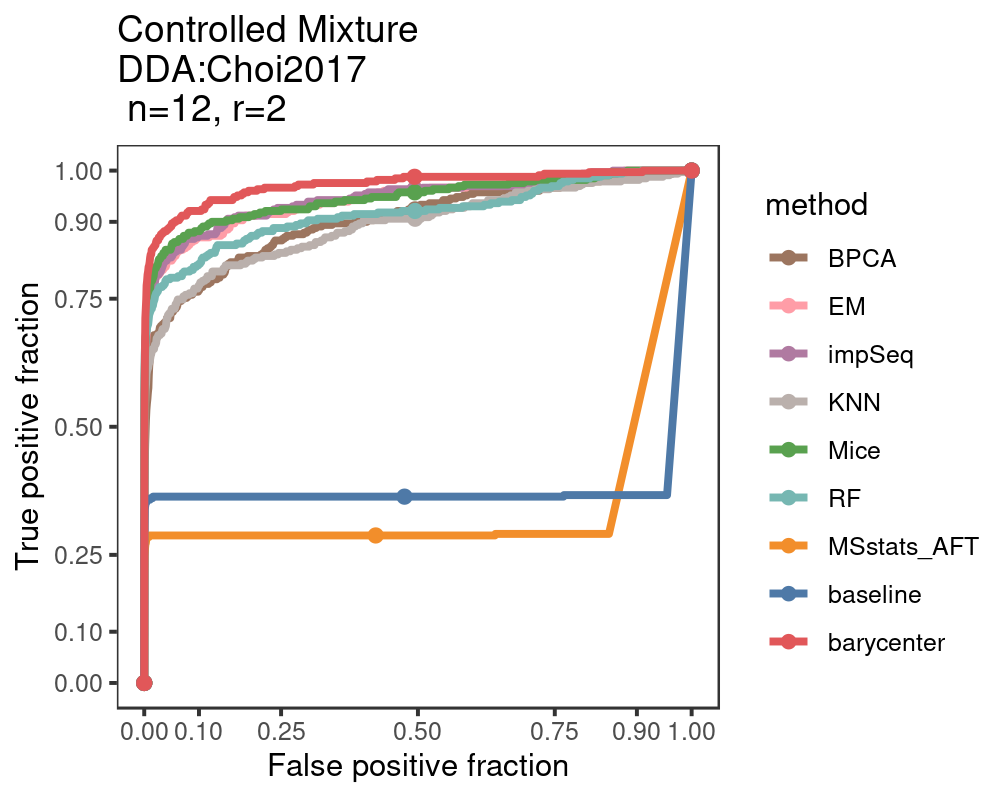

In [7]:
fig.size(4, 5)

# ROC curves
### Top N and ROC evaluations

library(plotROC)
library(patchwork)
library(ggthemes)


col_pal <- tableau_color_pal(palette = "Tableau 10", direction = -1)(9)
col_pal[col_pal == "#EDC948"] = "#BAB0AC"
names(col_pal) <- c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","barycenter","MSstats_AFT","baseline")

fullTables$method <- factor(fullTables$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","MSstats_AFT","baseline","barycenter"))



p2 <- ggplot(fullTables, aes(m = predictions, d = labels, group = method, color = method))+ geom_roc(n.cuts=3,labels=FALSE) +
   style_roc(guide = FALSE) +
  scale_color_manual(values = col_pal) +
  theme(panel.grid.major = element_blank(), panel.grid.minor = element_blank()
        #legend.position = "none"
       )


print(p2 + labs(title = "Controlled Mixture\nDDA:Choi2017\n n=12, r=2") )




fullTables2$method <- factor(fullTables2$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF",
                                        "MSstats_AFT","baseline","barycenter"))


null device 
          1

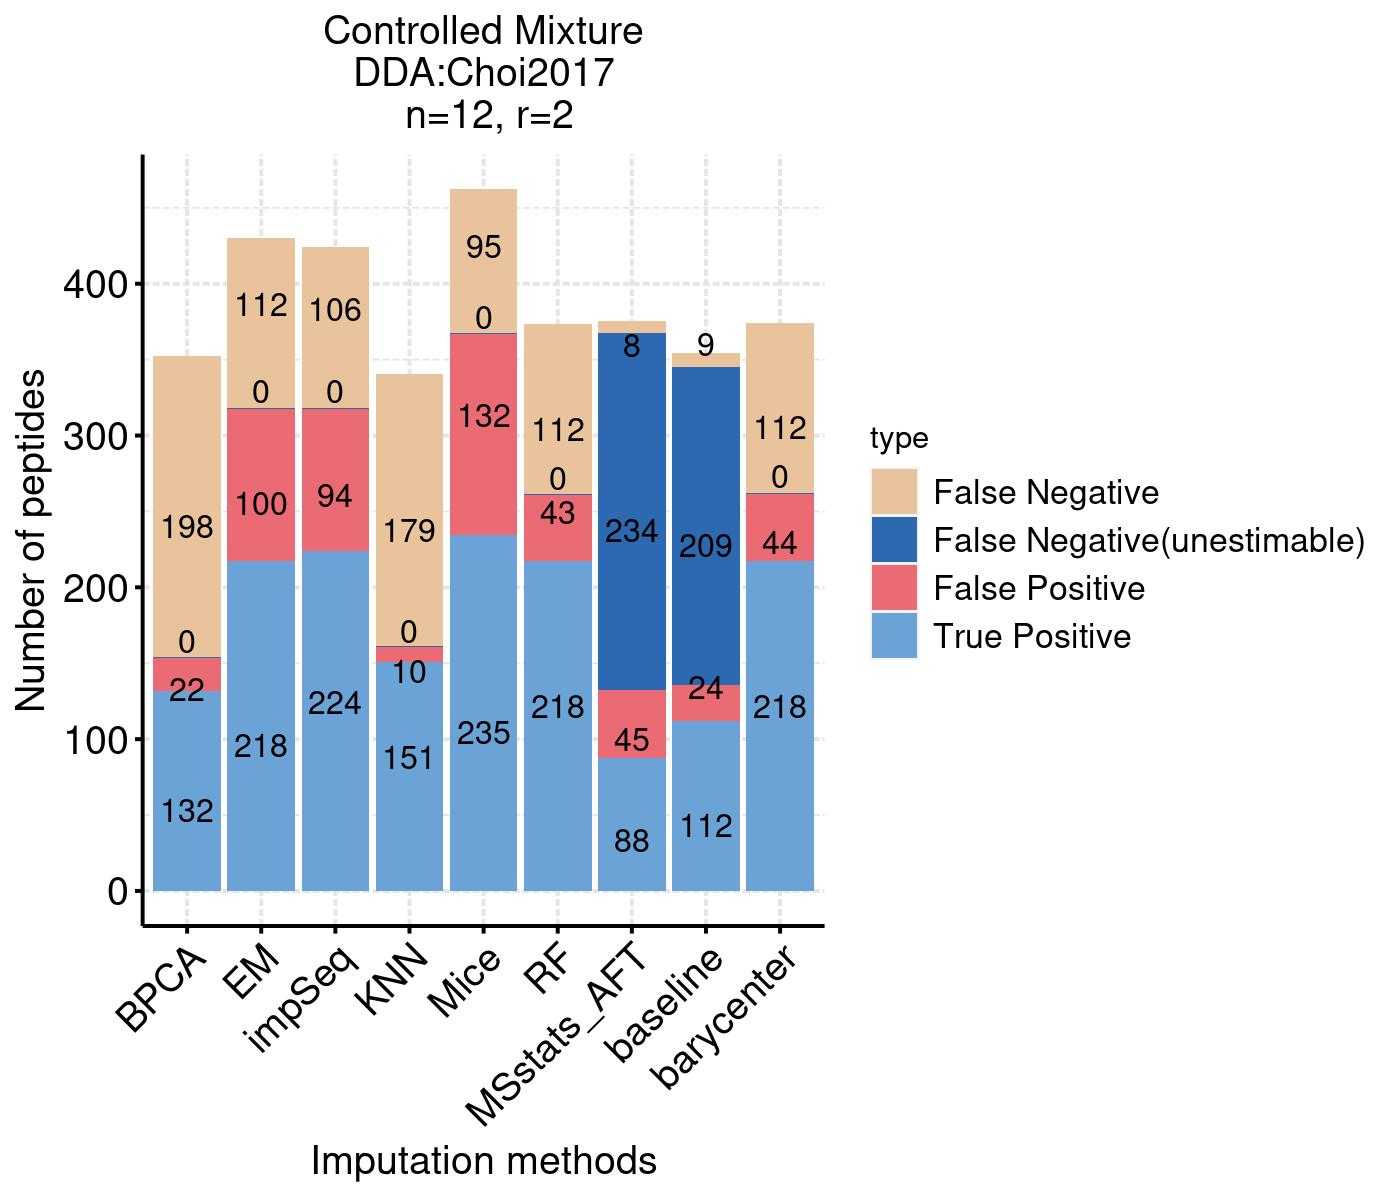

In [8]:
fig.size(6,7)

# Barplot of True positive, false positives and false negatives for all methods at FDR 0.05

ggdat <- fullTables2[,grep("method|total", colnames(fullTables2))]
ggdat <- ggdat[!duplicated(ggdat$method),]
colnames(ggdat) <- gsub("_total", "", colnames(ggdat))


ggdat <- reshape2::melt(ggdat, id = "method")
ggdat$method <- factor(ggdat$method, 
                             levels = c("BPCA", "EM", "impSeq", "KNN", "Mice", "RF","MSstats_AFT","baseline","barycenter"))


ggdat$variable <- gsub("TP", "True Positive", ggdat$variable)
ggdat$variable <- gsub('FN_unestim', 'False Negative(unestimable)', ggdat$variable)
ggdat$variable <- gsub("FP", "False Positive", ggdat$variable)
ggdat$variable <- gsub("FN", "False Negative", ggdat$variable)



# png(file = "~/barplot_PXD015300.png",
#     width=6,height=5,units="in",res=1200)

p <- ggplot(ggdat, aes(x=method, y = value, fill = variable, label=value)) +
  geom_bar(stat = "identity", position="stack") +
  ggrepel::geom_text_repel(size = 4, 
            position = position_stack(vjust = 0.5), direction = "y", 
            box.padding = unit(0.01, "lines")) + 
  xlab('Imputation methods') + ylab('Number of peptides') + 
  labs(fill="type", title = "Controlled Mixture\nDDA:Choi2017\n n=12, r=2") + 

  scale_fill_manual(values = c('False Negative(unestimable)' = "#2c69b0",
                               'False Negative' = "#e9c39b" ,
                               'True Positive' = "#6ba3d6", 
                               'False Positive' = "#ea6b73")) + 
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(angle = 45, vjust = 1, hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 

print(p)
dev.off()
p


FALSE  TRUE 
27456  1711 

png 
  2

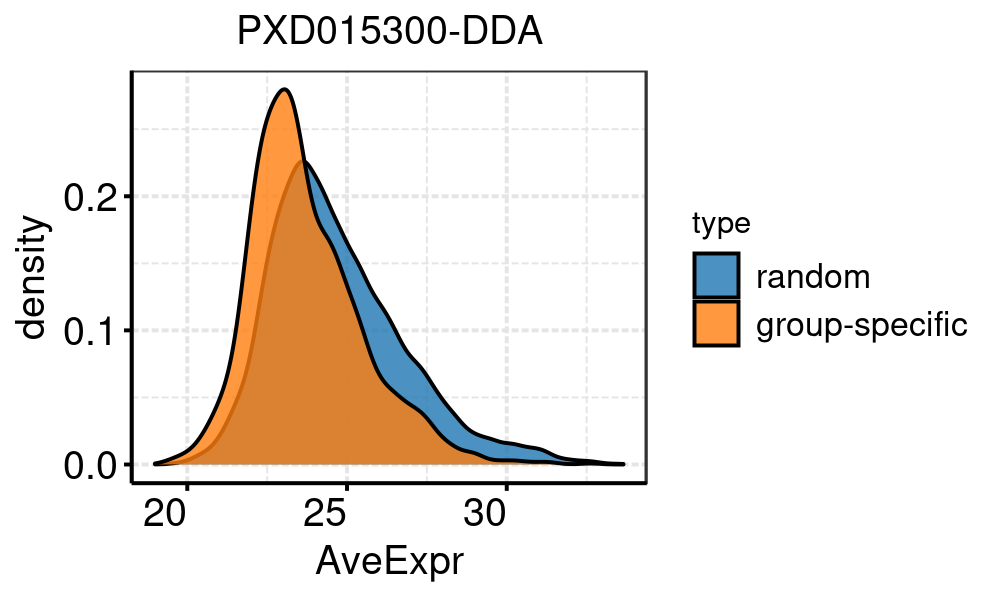

In [9]:
fig.size(3,5)

# Visualization of the ebm metric for assessment of missing types

hdp <- selectFeatures(y_dda,
                      method="ebm", group = group)

# hdp
table(hdp$msImpute_feature) # msImpute features are peptides that exhibit condition-specific missing values

ebms <- hdp$EBM
ebms[hdp$msImpute_feature] <- -1




library(ggExtra)

ggdat <- data.frame(hdp)
ggdat$metric <- ebms
ggdat$type <- ifelse(ggdat$metric == -1, "group-specific","random")
ggdat$type <- factor(ggdat$type, levels= c("random","group-specific"))


png(file = "~/hist_missingtype_PXD015300.png",
    width=5,height=3,units="in",res=1200)

p <- ggplot(ggdat, aes(x=AveExpr, fill = type)) +
  geom_density(alpha = 0.8) + scale_fill_d3() +
  theme_bw() + labs(title = "PXD015300-DDA")+
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) 


print(p)
dev.off()
p

png 
  2

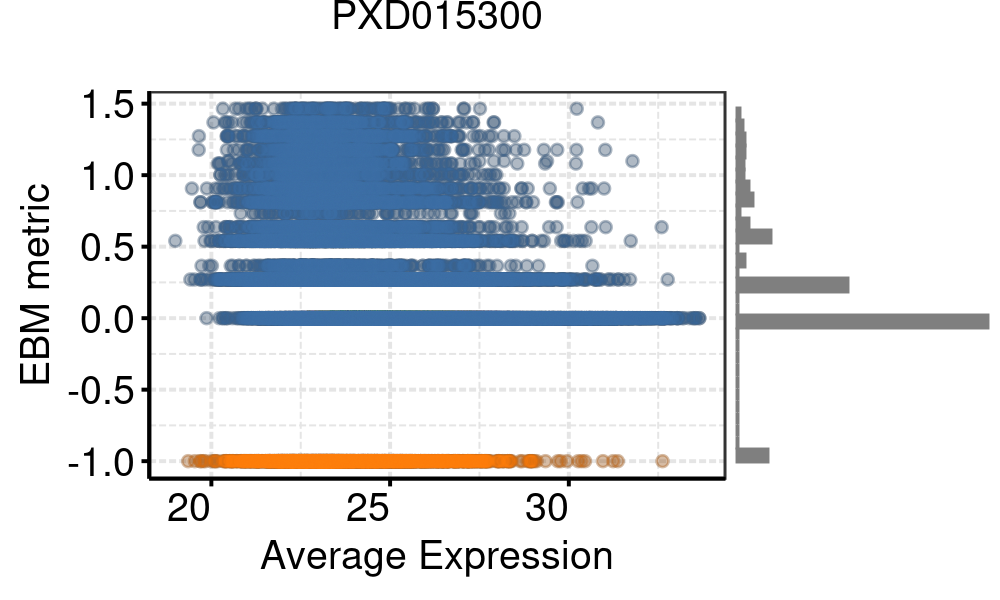

In [10]:
fig.size(3,5)

# EBM vs Ave abundance
p <- ggplot(ggdat, aes(x=AveExpr, y = metric)) +
  geom_point(alpha = 0.2) + 
  geom_point(data = subset(ggdat, metric == -1),alpha = 0.2, 
             color = "#FF7F0EFF") + 
  geom_point(data = subset(ggdat, metric != -1),alpha = 0.2, color = "#3E71A8") +
  #stat_bin_2d() +
  #geom_rug(sides = "b", alpha = 0.05) +
  theme_bw() +
  theme(axis.text.y = element_text(hjust = 1, size=14, color = "black"),
      axis.text.x = element_text(hjust=1, size = 14, color= "black"),
                strip.text.x = element_text(size=14),
                plot.title = element_text(hjust = 0.5, size = 14),
      axis.title=element_text(size=14),
      panel.background = element_rect(fill = "white",
                                colour = "white",
                                size = 3, linetype = "solid"),
  panel.grid.major = element_line(#size = 3,
                                  linetype = 'longdash',
                                colour = "grey90"), 
  panel.grid.minor = element_line(#size = 3, 
                                  linetype = 'longdash',
                                colour = "grey90"),
      axis.line = element_line(colour = "black"),
      axis.ticks = element_line(colour = "black"),
      legend.text=element_text(size=12)
                #legend.position = "none"
     ) + labs(x='Average Expression', y = 'EBM metric',
               title = "PXD015300")

p1 <- ggMarginal(p, type="histogram", margins = "y", 
                 fill = "gray50", color = "gray50", 
                 size = 2.1)


png(file = "~/scatter_ebm_abundance_PXD015300.png",
    width=5,height=3,units="in",res=1200)

print(p1)
dev.off()


p1 


FALSE  TRUE 
27456  1711 

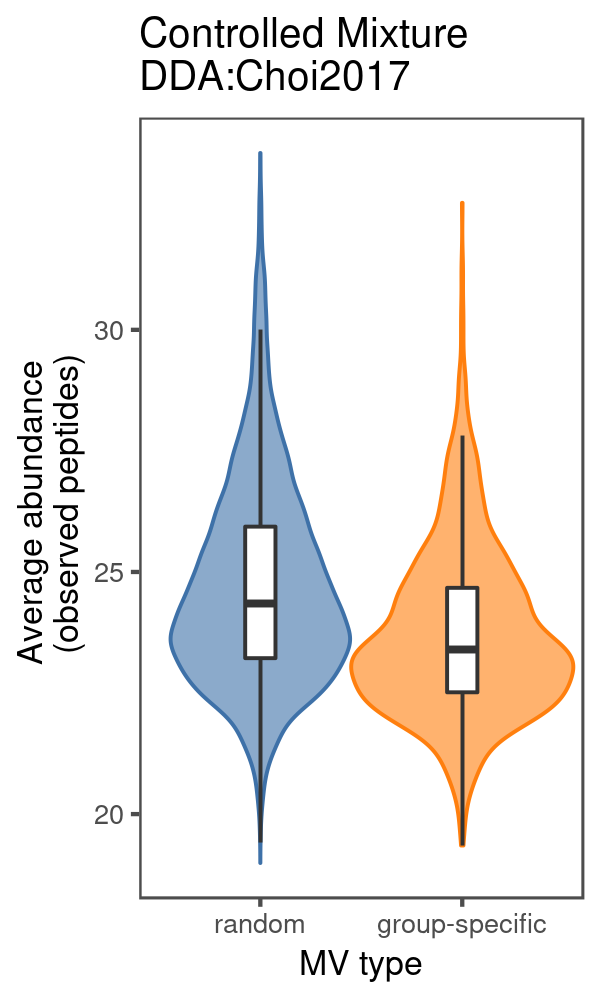

In [11]:
fig.size(5,3)
hdp <- selectFeatures(y_dda,
                      method="ebm", group = group)

#hdp
table(hdp$msImpute_feature) # msImpute features are peptides that exhibit condition-specific missing values

ebms <- hdp$EBM
ebms[hdp$msImpute_feature] <- -1




library(ggExtra)
library(ggthemes)

ggdat <- data.frame(hdp)
ggdat$metric <- ebms
ggdat$type <- ifelse(ggdat$metric == -1, "group-specific","random")
ggdat$type <- factor(ggdat$type, levels= c("random","group-specific"))



# png(file = paste0("revision_figures/violin_",dataset_name,".png"),
#     width=3.5,height=5.55, units="in",res=300)
pv <- ggplot(ggdat, aes(x=type, y = AveExpr)) + 
  geom_violin(aes(fill = type, color = type), alpha = 0.6, width = 1.1, show.legend = FALSE) +

  geom_boxplot(width=0.15, outlier.shape = NA) + 
  scale_fill_manual(values = c('random' = "#3E71A8", 'group-specific' = "#FF7F0EFF"))+
  scale_color_manual(values = c('random' = "#3E71A8", 'group-specific' = "#FF7F0EFF"))+
  labs(fill = '', y = 'Average abundance \n (observed peptides)', x = 'MV type',
       title = "Controlled Mixture\nDDA:Choi2017") +
  theme_few() 

print(pv)
# dev.off()

### Session information

In [12]:
sessionInfo()

R version 4.0.5 (2021-03-31)
Platform: x86_64-pc-linux-gnu (64-bit)
Running under: CentOS Linux 7 (Core)

Matrix products: default
BLAS:   /stornext/System/data/apps/R/R-4.0.5/lib64/R/lib/libRblas.so
LAPACK: /stornext/System/data/apps/R/R-4.0.5/lib64/R/lib/libRlapack.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] parallel  stats4    stats     graphics  grDevices utils     datasets 
[8] methods   base     

other attached packages:
 [1] ggExtra_0.9         ggthemes_4.2.4      patchwork_1.1.1    
 [4] plotROC_2.2.1       MSstats_3.22.1      msImpute_1.7.1     
 [7] rrcovNA_0.4-15      rrcov_1.6-0         robustbase_0.93-7  
[10] ggsci_2.9        